In [1]:
#data manipulation
import pandas as pd
import datetime
import numpy as np
import random

#vis
import matplotlib.pyplot as plt

#keras
import tensorflow
from tensorflow import keras
from keras import losses
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal


In [2]:
df = pd.read_csv("philly2.csv")
df.drop('Sunrise', inplace=True, axis=1)
df.drop('Sunset', inplace=True, axis=1)
df.drop('Altitude', inplace=True, axis=1)
df.drop('Dew Point Temp', inplace=True, axis=1)
df.drop('Precipitation', inplace=True, axis=1)
df.drop('Pressure Change', inplace=True, axis=1)

df.drop('Station Pressure', inplace=True, axis=1)
df.drop('Visibility', inplace=True, axis=1)
df.drop('Wet Bulb Temp', inplace=True, axis=1)
df.drop('Wind Direction', inplace=True, axis=1)
df.drop('Sky Conditions', inplace=True, axis=1)
df.drop('Pressure Tendency', inplace=True, axis=1)
df.head()

,DATE,Dry Bulb Temp,Humidity,Wind Speed
0,"January 1, 2018, 00:54",10.0,50.0,6.0
1,"January 1, 2018, 01:00",10.0,50.0,6.0
2,"January 1, 2018, 01:54",9.0,52.0,7.0
3,"January 1, 2018, 02:54",10.0,48.0,8.0
4,"January 1, 2018, 03:54",9.0,50.0,7.0


In [3]:
df.count()

DATE             40590
Dry Bulb Temp    39447
Humidity         39445
Wind Speed       39448
dtype: int64

In [4]:
df = df.dropna(how='any',axis=0)
df.count()

DATE             39439
Dry Bulb Temp    39439
Humidity         39439
Wind Speed       39439
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39439 entries, 0 to 40587
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DATE           39439 non-null  object 
 1   Dry Bulb Temp  39439 non-null  float64
 2   Humidity       39439 non-null  float64
 3   Wind Speed     39439 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB


In [6]:
#converting to datetime
df['DATE'] = [datetime.datetime.strptime(x,"%B %d, %Y, %H:%M") for x in df["DATE"]]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39439 entries, 0 to 40587
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           39439 non-null  datetime64[ns]
 1   Dry Bulb Temp  39439 non-null  float64       
 2   Humidity       39439 non-null  float64       
 3   Wind Speed     39439 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [8]:
#seperating the hour 
df["hour"] = [x.hour for x in df["DATE"]]

#set hour to a sin and cosine function so that 23 and 0 are connected in the seqauence of data
df["cosDay"] = [np.cos(x * (2 * np.pi / 24)) for x in df["hour"]]
df["sinDay"] = [np.sin(x * (2 * np.pi / 24)) for x in df["hour"]]
df.head(24)

,DATE,Dry Bulb Temp,Humidity,Wind Speed,hour,cosDay,sinDay
0,2018-01-01 00:54:00,10.0,50.0,6.0,0,1.000000e+00,0.000000e+00
1,2018-01-01 01:00:00,10.0,50.0,6.0,1,9.659258e-01,2.588190e-01
2,2018-01-01 01:54:00,9.0,52.0,7.0,1,9.659258e-01,2.588190e-01
3,2018-01-01 02:54:00,10.0,48.0,8.0,2,8.660254e-01,5.000000e-01
4,2018-01-01 03:54:00,9.0,50.0,7.0,3,7.071068e-01,7.071068e-01
5,2018-01-01 04:54:00,9.0,50.0,9.0,4,5.000000e-01,8.660254e-01
6,2018-01-01 05:54:00,9.0,50.0,8.0,5,2.588190e-01,9.659258e-01
7,2018-01-01 06:54:00,7.0,57.0,7.0,6,6.123234e-17,1.000000e+00
8,2018-01-01 07:00:00,7.0,57.0,7.0,7,-2.588190e-01,9.659258e-01
9,2018-01-01 07:54:00,8.0,57.0,8.0,7,-2.588190e-01,9.659258e-01


In [9]:
#extract timestamp
df["tstamp"] = [x.timestamp() for x in df["DATE"]]

secDay = 24*60*60
secYear = (365.25) * secDay

df["month_cos"] = [np.cos((x) * (2 * np.pi / secYear)) for x in df["tstamp"]]
df["month_sin"] = [np.sin((x) * (2 * np.pi / secYear)) for x in df["tstamp"]]


In [10]:
def createXY(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    
    n_features = ts.shape[1]
    
    X, Y = [],[]
    
    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])
    
    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [11]:
#number of previos hours to use in forcast
lag = 256

#steps
n_ahead = 12

#test %
test_share = 0.1

#training epochs
epochs = 100

#batch size
batch = 64
#learning rate
lr = 0.001

#nuerones used for LSTM layer
n_layer = 10

#features being used
features = ['Dry Bulb Temp', 'cosDay', 'sinDay', 'month_sin', 'month_cos', 'Wind Speed', 'Humidity']

In [12]:
class NNMultistepModel():
    
    def __init__(
        self, 
        X, 
        Y, 
        n_outputs,
        n_lag,
        n_ft,
        n_layer,
        batch,
        epochs, 
        lr,
        Xval=None,
        Yval=None,
        mask_value=-999.0,
        min_delta=0.001,
        patience=5
    ):
        lstm_input = Input(shape=(n_lag, n_ft))

        # Series signal 
        lstm_layer = LSTM(n_layer, activation='relu')(lstm_input)

        x = Dense(n_outputs)(lstm_layer)
        
        self.model = Model(inputs=lstm_input, outputs=x)
        self.batch = batch 
        self.epochs = epochs
        self.n_layer=n_layer
        self.lr = lr 
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.mask_value = mask_value
        self.min_delta = min_delta
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience, min_delta=self.min_delta)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate=self.lr)

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [13]:
# Subseting only the needed columns 
ts = df[features]
nrows = ts.shape[0]
# Spliting into train and test sets
train = ts[0:int(nrows * (1 - 0.1))]
test = ts[int(nrows * (1 - 0.1)):]
# Scaling the data 
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std
# Creating the final scaled frame 
ts_s = pd.concat([train, test])
# Creating the X and Y for training
X, Y = createXY(ts_s.values, lag=lag, n_ahead=n_ahead)
n_ft = X.shape[2]

In [14]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [19]:
# Initiating the model object
model = NNMultistepModel(
 X=Xtrain,
 Y=Ytrain,
 n_outputs=n_ahead,
 n_lag=lag,
 n_ft=n_ft,
 n_layer=n_layer,
 batch=batch,
 epochs=epochs, 
 lr=lr,
 Xval=Xval,
 Yval=Yval,
)
# Training of the model 
history = model.train()

Epoch 1/100
551/551 [==============================] - 18s 32ms/step - loss: 0.7177 - val_loss: 0.3700
Epoch 2/100
551/551 [==============================] - 17s 31ms/step - loss: 0.3303 - val_loss: 0.2654
Epoch 3/100
551/551 [==============================] - 18s 33ms/step - loss: 0.2438 - val_loss: 0.2400
Epoch 4/100
551/551 [==============================] - 19s 34ms/step - loss: 0.2120 - val_loss: 0.2216
Epoch 5/100
551/551 [==============================] - 19s 34ms/step - loss: 0.1852 - val_loss: 0.2114
Epoch 6/100
551/551 [==============================] - 18s 33ms/step - loss: 0.1688 - val_loss: 0.2008
Epoch 7/100
551/551 [==============================] - 18s 34ms/step - loss: 0.1600 - val_loss: 0.1845
Epoch 8/100
551/551 [==============================] - 19s 34ms/step - loss: 0.1542 - val_loss: 0.1735
Epoch 9/100
551/551 [==============================] - 19s 34ms/step - loss: 0.1498 - val_loss: 0.1655
Epoch 10/100
551/551 [==============================] - 19s 34ms/step - l

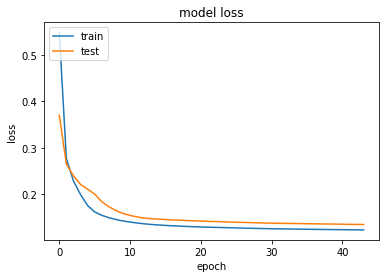

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]
# Creating the frame to store both predictions
days = df['DATE'].values[-len(y):]
frame = pd.concat([
 pd.DataFrame({'day': days, 'Dry Bulb Temp': y, 'type': 'original'}),
 pd.DataFrame({'day': days, 'Dry Bulb Temp': yhat, 'type': 'forecast'})
])
# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std['Dry Bulb Temp']) + train_mean['Dry Bulb Temp'] for x in frame['Dry Bulb Temp']]
# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]

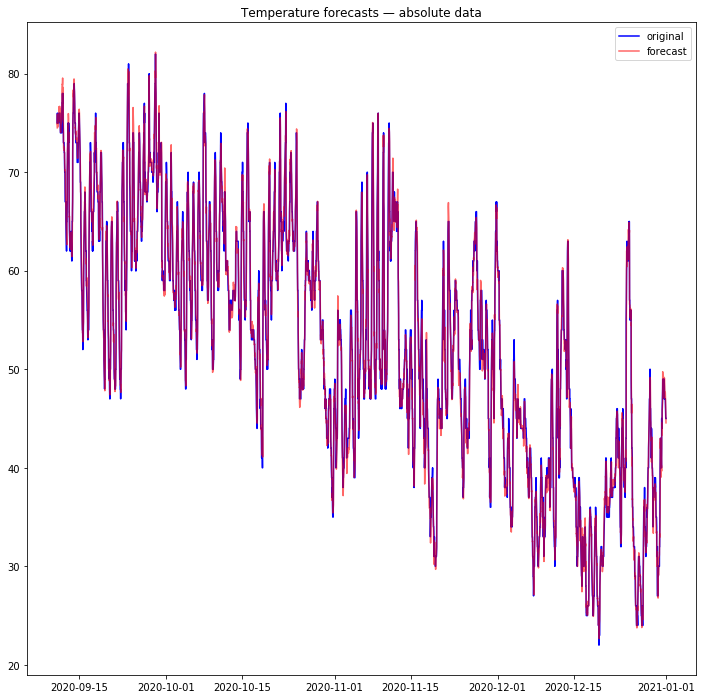

In [23]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.temp_absolute_original, color='blue', label='original')
plt.plot(pivoted.index, pivoted.temp_absolute_forecast, color='red', label='forecast', alpha=0.6)
plt.title('Temperature forecasts — absolute data')
plt.legend()
plt.show()

In [33]:
model.fit

AttributeError: 'NNMultistepModel' object has no attribute 'fit'

dtype('float64')